# NDVI Calculation

In [3]:
import sys
sys.path.append('../')

In [4]:
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import lithops
import time
import shutil
import os
import gc
from rasterio.io import MemoryFile
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from lithops import Storage

import cloudbutton_geospatial.s2froms3 as s2froms3
from cloudbutton_geospatial.utils import notebook as notebook_utils
from cloudbutton_geospatial.io_utils.ndvi import get_ndvi_params, ndvi_calculation, ndvi_tile_sentinel, get_subset_raster, lonlat_to_utm, get_poly_within
from cloudbutton_geospatial.io_utils.plot import tiff_overview, plot_map

%matplotlib inline

## Input parameters

Select the date interval in which tiles will be processed:

In [5]:
from_date, to_date = notebook_utils.pick_date_range()

DatePicker(value=datetime.date(2019, 9, 17), description='From day')

DatePicker(value=datetime.date(2021, 9, 16), description='To day')

Select the tile's cloud percentage threshold:

In [6]:
percentage = notebook_utils.pick_percentage_slider()

IntSlider(value=0, continuous_update=False, description='Percentage of cloudiness')

Select the area which delimites the tiles you want to process (left click to mark a point in the map, right click to erase current selection):

In [10]:
map_region = notebook_utils.MapRegion()

Map(center=[39.60595289727246, -122.82804126978336], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [11]:
coord = map_region.get_region()[0] #[-122.72001061072717, 39.25990481501755] 
lat = coord[1]  # latitude
lon = coord[0]  # longitude

start_date = from_date.value  # Start date to search images
end_date = to_date.value  # End date to search images
what = ['B04', 'B08']  # What we want to download
cc = percentage.value  # Minimum cloud cover on each image, 25 is 25%

print([lat, lon], start_date, end_date, what, cc)

[39.500199536743445, -122.80508405617829] 2019-09-17 2021-09-16 ['B04', 'B08'] 0


## Get Sentinel-2 packages

In [ ]:
# Get scenes from intital date
scenes_f1 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                    start_date=start_date,
                                    end_date=start_date,
                                    what=what,
                                    cloud_cover_le=cc)
print(f'Found scenes {start_date}:', scenes_f1)

# get scenes from end date
scenes_f2 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                    start_date=end_date,
                                    end_date=end_date,
                                    what=what,
                                    cloud_cover_le=cc)
print(f'Found scenes {end_date}:', scenes_f2)

scene = scenes_f1[-1]
scene_band = rasterio.open('s3://'+scene[0])
windows = list(scene_band.block_windows())
windows

In [ ]:
def calculate_ndvi(scene, ij_window, storage):

    ij, window = ij_window
    band_4_s3_loc, band_8_s3_loc = scene
    band_path = band_4_s3_loc.split('/')
    ndvi_local = f'/tmp/{band_path[7]}_{ij}_NDVI.tif'
    jpg_local = f'/tmp/{band_path[7]}_{ij}_NDVI.jpg'

    # generate nir and red objects as arrays in float64 format
    # Read from S3 to lambda
    #print(storage.head_object('s3://'+band_4_s3_loc))
    #print(storage.head_object('s3://'+band_8_s3_loc))
    
    band4 = rasterio.open('s3://'+band_4_s3_loc)  # red
    band8 = rasterio.open('s3://'+band_8_s3_loc)  # nir

    profile = band4.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    with rasterio.open(ndvi_local, 'w', **profile) as dst:
        red = band4.read(1, window=window).astype('float64')
        nir = band8.read(1, window=window).astype('float64')
        ndvi = (np.where((nir + red) == 0., 0, (nir - red) / (nir + red))).astype('float64')
        ndvi_mean = np.mean(ndvi, axis=0)
        dst.write(ndvi, 1)
        ndvi[0][0] = -1
        ndvi[0][1] = 1
        plt.imsave(jpg_local, ndvi, cmap="RdYlGn")
        
    print(storage.head_object(f'/tmp/{band_path[7]}_{ij}_NDVI.tif')
    
    # esto realmente solo lo usa para mostrar la imagen en el codigo final, se pueden ahorrar muchos puts con esto
    #with open(jpg_local, 'rb') as jpg_temp:
        #co_jpg = storage.put_cloudobject(jpg_temp.read(), key=jpg_local.replace('/tmp/', ''))
    
    #with open(ndvi_local, 'rb') as ndvi_temp:
        #co_ndvi = storage.put_cloudobject(ndvi_temp.read(), key=ndvi_local.replace('/tmp/', ''))

    return ndvi_local, ndvi_mean, co_jpg, throughput_read, throyp


def compute_ndvi_diff(old_scene, new_scene, ij_window, storage):

    ij, window = ij_window
    band_path = new_scene[0].split('/')
    jpg_diff_local = f'/tmp/{band_path[7]}_{ij}_NDVI_DIFF.jpg'

    ndvi_local_f1, ndvi_mean_f1, co_jpg_f1 = calculate_ndvi(old_scene, ij_window, storage)
    ndvi_local_f2, ndvi_mean_f2, co_jpg_f2 = calculate_ndvi(new_scene, ij_window, storage)

    ndvi_old = rasterio.open(ndvi_local_f1)
    ndvi_new = rasterio.open(ndvi_local_f2)

    profile = ndvi_old.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    no = ndvi_old.read(1).astype('float64')
    nn = ndvi_new.read(1).astype('float64')
    ndvi_cmp = ((nn - no) * (nn + no)).astype('float64')
    ndvi_cmp[0][0] = -1
    ndvi_cmp[0][1] = 1
    plt.imsave(jpg_diff_local, ndvi_cmp, cmap="RdYlGn")

    # esto realmente solo lo usa para mostrar la imagen en el codigo final, se pueden ahorrar muchos puts con esto
    with open(jpg_diff_local, 'rb') as jpg_diff_file:
        co_jpg_diff = storage.put_cloudobject(jpg_diff_file, key=jpg_diff_local.replace('/tmp/', ''))

    return ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff,

Using the selected parameters, get the identifiers of the selected tiles from Sentinel-2:

In [ ]:

compute_ndvi_diff(scenes_f1[0], scenes_f2[0], wd, 'aws_s3')


In [ ]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='DEBUG',
        monitoring='rabbitmq',
        max_workers=1,
        runtime='aws_lambda/lithops-ndvi-v39:01'  # Runtime for AWS Lambda
)
    #runtime_memory=1024,
    #max_workers=10,

iterdata = [(scenes_f1[0], scenes_f2[0], wd) for wd in windows]
fexec.map(compute_ndvi_diff, iterdata)
results = fexec.get_result()

# Plots
fexec.plot(dst='C:\\Users\\alega\\Desktop\\lithops' + str([lat, lon]))

In [ ]:
# Statistics: 
startTime = set()
execTime = set()
endTime = set()
tstamps = set()

for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("tstamp"):
            tstamps.add(future.stats[key])
        if key.endswith("worker_func_start_tstamp"):
            startTime.add(future.stats[key])
        if key.endswith("worker_func_exec_time"):
            execTime.add(future.stats[key])
        if key.endswith("worker_end_tstamp"):
            endTime.add(future.stats[key])
            
            
duration = max(endTime) - min(startTime)
speedup = max(tstamps) - min(tstamps)

In [ ]:
fexec.futures.stats

In [32]:
# Speedup: 
print(speedup)

36.08844614028931


In [33]:
# Duration:
print(duration)

17.125915050506592


In [21]:
# Data size of temporal images:
cloud_storage = Storage(backend='aws_s3')
BUCKET = 'daniel-lithops-geospatial'

data_size = sum(obj["Size"] for obj in cloud_storage.list_objects(BUCKET))
print(f"Data size: {data_size / 1024 ** 2} MiB")

2022-05-24 20:04:37,623 [DEBUG] lithops.config -- Loading configuration from C:\Users\alega\PycharmProjects\geospatial-usecase\ndvi-diff\.lithops_config
2022-05-24 20:04:37,627 [DEBUG] lithops.config -- Loading Storage backend module: aws_s3
2022-05-24 20:04:37,628 [DEBUG] lithops.storage.backends.aws_s3.aws_s3 -- Creating S3 client
2022-05-24 20:04:37,760 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-1


Data size: 56.359249114990234 MiB


In [27]:
# Throughput:
# TO-DO: Get data size correctly and make throuput of write and read
throughput_interpolation = data_size / duration  # Bytes/second
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

Throughput: 3.290875199881545 MiB/s


In [36]:
# Number of workers:
numberWorkers=len(fexec.futures)
print(numberWorkers)

121


In [39]:
# Duration average per worker:
durationPerWorker=sum(execTime) / numberWorkers
print(durationPerWorker)

12.772764856363636


## Get and plot the computed jpg diff tile image

In [28]:
def get_jpg(data):
    file = '_'.join(data[0][1].key.split('_')[:5])
    
    if 'DIFF' in data[0][1].key:
        out_file = f'AwsData/{file}_NDVI_DIFF.jpg'
    else:
        out_file = f'AwsData/{file}_NDVI.jpg'
        
    jpgs = {}

    def get_window(data):
        ij_window, co_jpg = data
        row = ij_window[0][0]
        col = ij_window[0][1]
        jpg_stream = fexec.storage.get_cloudobject(co_jpg, stream=True)

        if row not in jpgs:
            jpgs[row] = [None]*11

        jpgs[row][col] = Image.open(jpg_stream)

    with ThreadPoolExecutor(max_workers=len(data)) as ex:
        fs = ex.map(get_window, data)

    new_im = Image.new('RGB', (scene_band.width, scene_band.height))

    x_offset = 0
    y_offset = 0

    for row in sorted(jpgs.keys()):
        for im in jpgs[row]:
            new_im.paste(im, (x_offset, y_offset))
            x_offset += im.size[0]
        x_offset = 0
        y_offset += im.size[1]
        
    thumbnail_zise = (640, 640)
    new_im.thumbnail(thumbnail_zise)

    #fig = plt.figure(figsize=(10, 10))
    #plt.title(out_file)
    #plt.imshow(new_im)
    images[out_file] = new_im

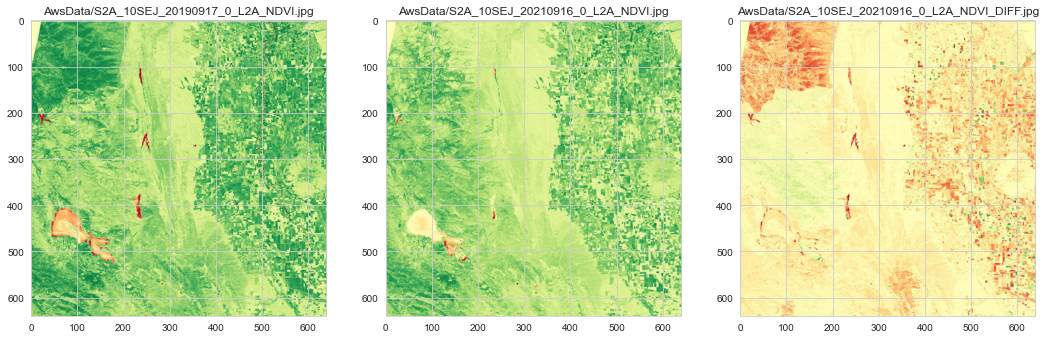

In [29]:
co_jpgs_f1 = [(res[0], res[1]) for res in results]
co_jpgs_f2 = [(res[0], res[2]) for res in results]
co_jpgs_diff = [(res[0], res[3]) for res in results]

images = {}
with ThreadPoolExecutor(max_workers=3) as ex:
    fs = ex.map(get_jpg, [co_jpgs_f1, co_jpgs_f2, co_jpgs_diff])

f, ax = plt.subplots(1,3, figsize=(18, 18))
i = 0
for j in sorted(images.keys()):
    ax[i].set_title(j)
    ax[i].imshow(images[j])
    i = i+1
plt.show() 